In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from CapsuleNet import CapsuleNetwork, CapsuleLoss, display_images
from utils_original import DICOMCoarseDataset, display_data_loader_batch, TransformDataset

In [3]:
scenario = 1
data_augmentation = False

In [4]:
BASE_DIR = "D:/Datasets/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
classes = ["nodule", "non-nodule"]
train_ratio = 0.8
image_size = 80

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

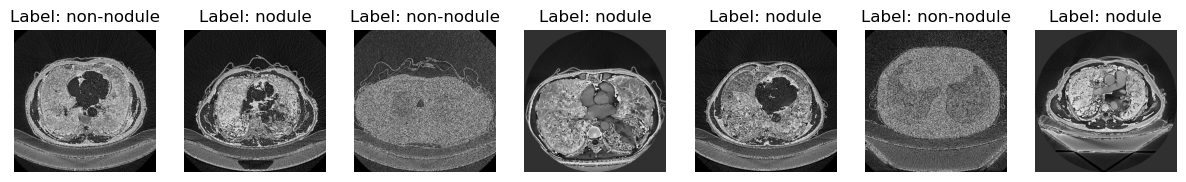

In [5]:
train_transforms = None

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

if data_augmentation:
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
        transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
                        scale=(0.8, 1.2),  # Scale for zoom in/out
                        ratio=(0.9, 1.1)),
        transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
        transform
    ])
else: 
    train_transforms = transform

dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=["nodule", "non-nodule"], scenario=scenario)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=["nodule", "non-nodule"], transform=transform, scenario=1)
dataset.visualize_images(num_images=7)

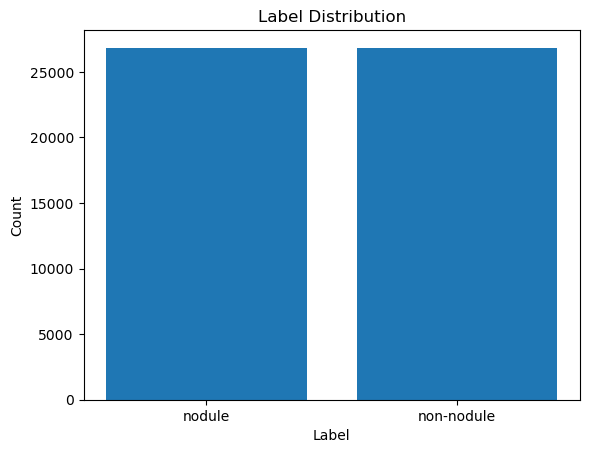

In [6]:
dataset.display_label_distribution()

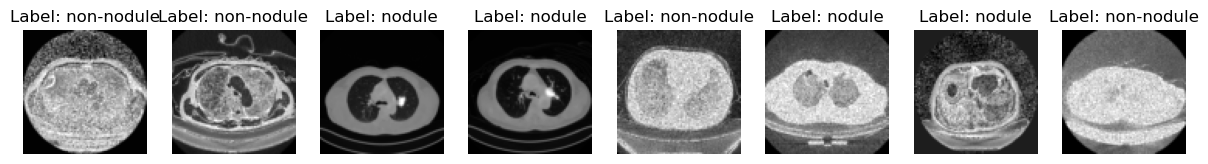

In [7]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataset = TransformDataset(torch.utils.data.Subset(dataset, train_dataset.indices), transform=train_transforms)
test_dataset = TransformDataset(torch.utils.data.Subset(dataset, test_dataset.indices), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(train_loader, classes)

In [8]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=6400, bias=True)
      (5): Sigmoid()
    )
  )
)


In [9]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [10]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)

Epoch: 1 	Training Loss: 8.42527199
Epoch: 1 	Training Loss: 4.07520390
Epoch: 1 	Training Loss: 3.89240003
Epoch: 1 	Training Loss: 4.00857067
Epoch: 1 	Training Loss: 3.84171605
Epoch: 1 	Training Loss: 3.79816055
Epoch: 1 	Training Loss: 3.40611887
Epoch: 1 	Training Loss: 3.34342861
Epoch: 1 	Training Loss: 2.86036897
Epoch: 1 	Training Loss: 2.77952981
Epoch: 1 	Training Loss: 2.78098917
Epoch: 1 	Training Loss: 2.74263716
Epoch: 1 	Training Loss: 2.41069102
Epoch: 1 	Training Loss: 2.40898252
Epoch: 1 	Training Loss: 2.19182968
Epoch: 1 	Training Loss: 2.05584884
Epoch: 1 	Training Loss: 1.96522939
Epoch: 1 	Training Loss: 1.76439691
Epoch: 1 	Training Loss: 2.05038381
Epoch: 1 	Training Loss: 1.95598173
Epoch: 1 	Training Loss: 1.81450188
Epoch: 1 	Training Loss: 1.90825796
Epoch: 1 	Training Loss: 1.86658025
Epoch: 1 	Training Loss: 1.79140329
Epoch: 1 	Training Loss: 1.77922618
Epoch: 1 	Training Loss: 1.60853732
Epoch: 1 	Training Loss: 1.82912409
Epoch: 1 	Training Loss: 1.8

Test Loss: 1.30417101

Test Accuracy of     0: 95.70% (5135/5366)
Test Accuracy of     1: 89.71% (4819/5372)

Test Accuracy (Overall): 92.70% (9954/10738)


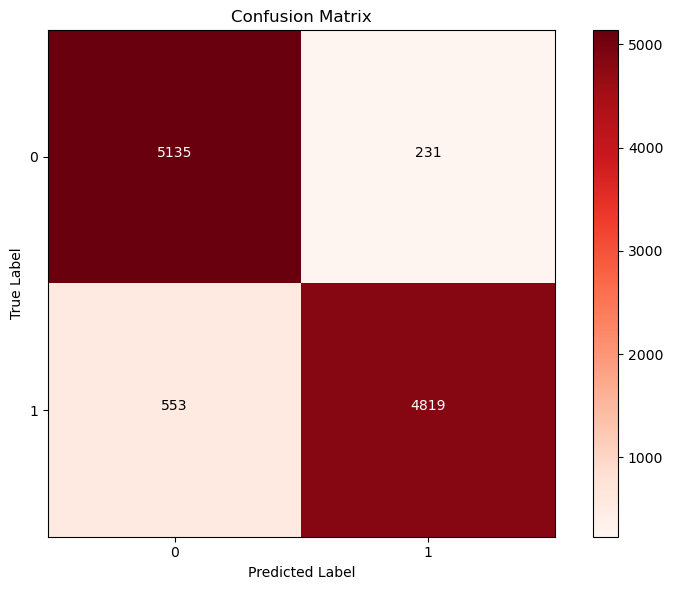

In [11]:
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

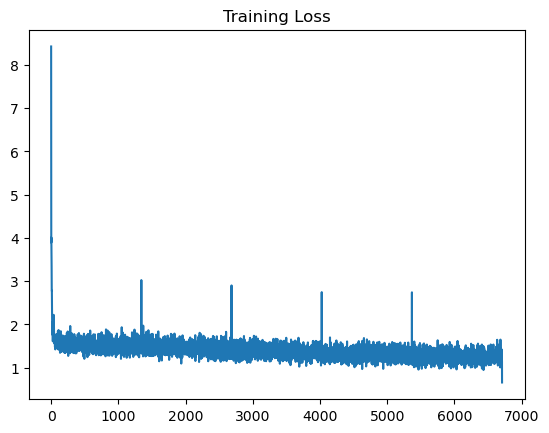

In [12]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

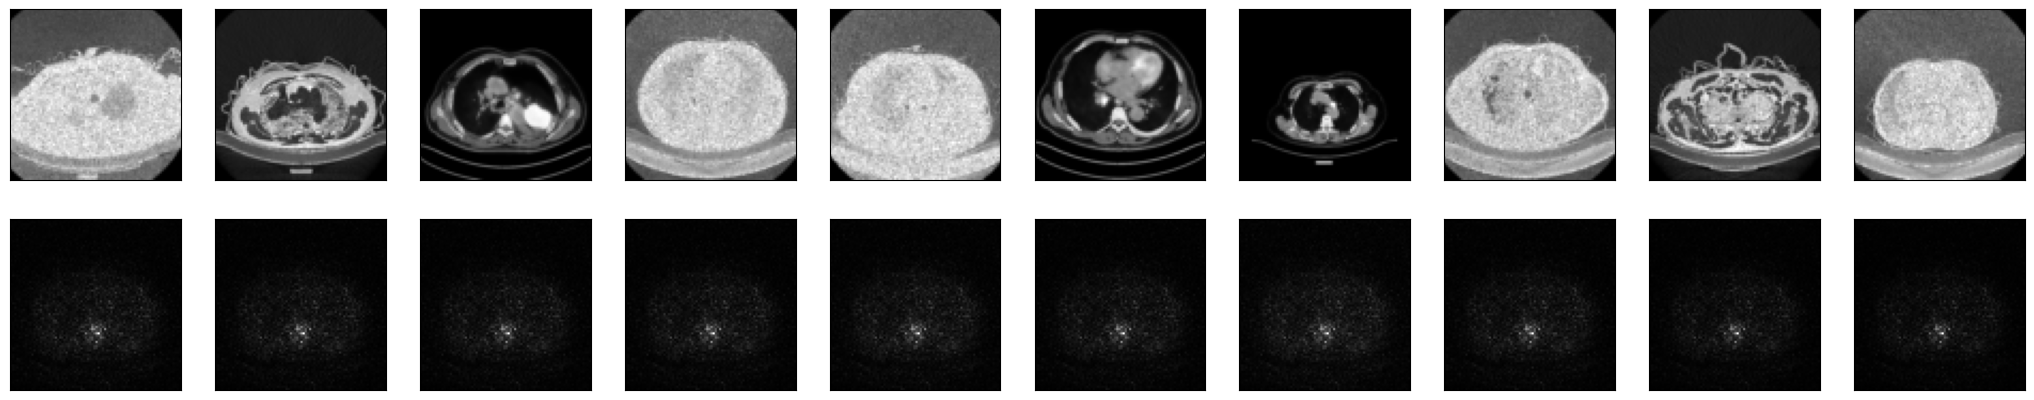

In [13]:
display_images(images, reconstructions)